In [382]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
def f(x):
  return 3*x**2 - 4*x + 5

In [12]:
f(3.0)

20.0

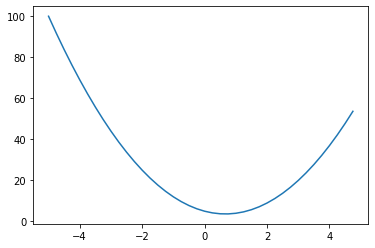

In [15]:
## Visualising the above function using plot
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [42]:
## A very simple approximation of the above funtion
# Done by adding a small value h, to see how the function has "Differentiated"

h = 0.000001
x = 2/3
(f(x + h) - f(x))/h

2.999378523327323e-06

In [43]:
# les get more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [50]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

## Approximation by increasing c
d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)


d1 4.0
d2 4.0001
slope 0.9999999999976694


### Defining our very own value class to have control over all mathematical operations and their respective gradiant computations

In [328]:

class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      ## Addition would distribute the already existing gradiant. So out.grad is multiplied to follow the chain rule
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      ## Multiplication would replicate the value on the alternate cell
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        ## x**n = n * x**(n-1)
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      ## https://en.wikipedia.org/wiki/Hyperbolic_functions#Derivatives
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      ## since d/dx e**x = e**x
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()



In [139]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


### Mathematically simulating forward pass on one neuron

In [318]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

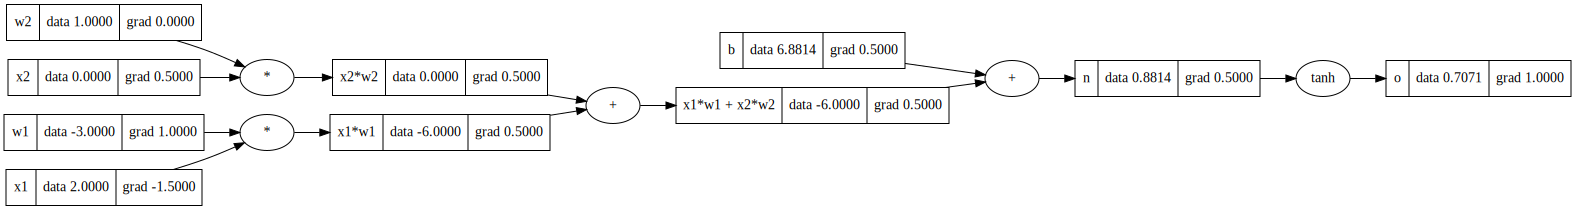

In [319]:
draw_dot(o)

### Adding tanh non linearity to output

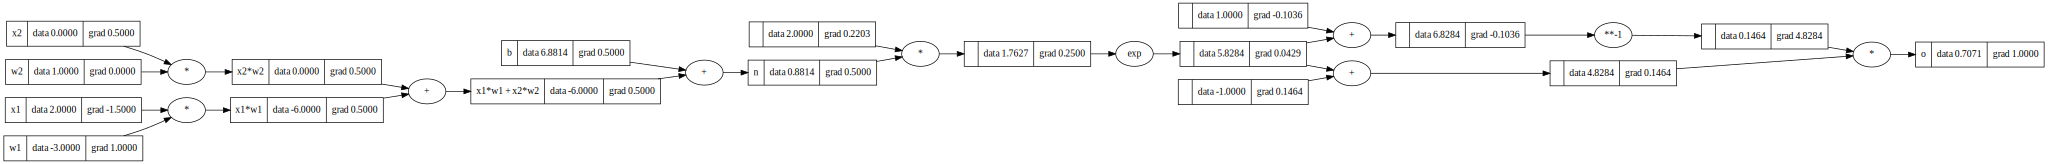

In [320]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ---- Tanh
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

In [369]:
import torch

### Verifying the mathematical gradiant with torch

In [376]:

x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


### Creating a neural network mathematically

In [592]:


class Neuron:
  ## initialising w and b required for one neuron; the number of w's depend on inputs
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  
  def parameters(self):
    ## would return all the parameters defined
    return self.w + [self.b]

class Layer:
  
  def __init__(self, nin, nout):
    ## Consists of a list of multiple neurons; each neuron would accept multiple inputs 
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    ### Running forward pass on each and every neuron
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]


In [665]:
x = [2.0, 3.0, -1.0]
## 3 inputs, 2 hidden layers with 4 neuron each and one output
n = MLP(3, [4, 4, 1])
## Forward pass
n(x)

Value(data=0.16578526021381612)

### Running a complex example

In [666]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

### Visualising ypred loss

In [682]:

for k in range(20):
  
  # forward pass
  ypred = [n(x) for x in xs]
  ## Squared error : (y^ - y)**2 on each example input then summed together
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in n.parameters():
    ## Initialising gradiants before each iteration to delete previous gradiants
    p.grad = 0.0
  ## Calculating current gradiants
  loss.backward()
  
  # update
  for p in n.parameters():
    ## Slightly nudging every single parameter towards the calculated gradiants
    p.data += -0.1 * p.grad
  
  print(k, loss.data)
  

0 0.002056123958292787
1 0.0020404768419831024
2 0.0020250564320649566
3 0.002009857924015696
4 0.001994876646733686
5 0.0019801080579702683
6 0.001965547739947282
7 0.0019511913951512907
8 0.0019370348422964524
9 0.0019230740124479978
10 0.001909304945299319
11 0.0018957237855951486
12 0.0018823267796946328
13 0.0018691102722676993
14 0.0018560707031189828
15 0.0018432046041333716
16 0.0018305085963379896
17 0.0018179793870754363
18 0.0018056137672833098
19 0.0017934086088756394


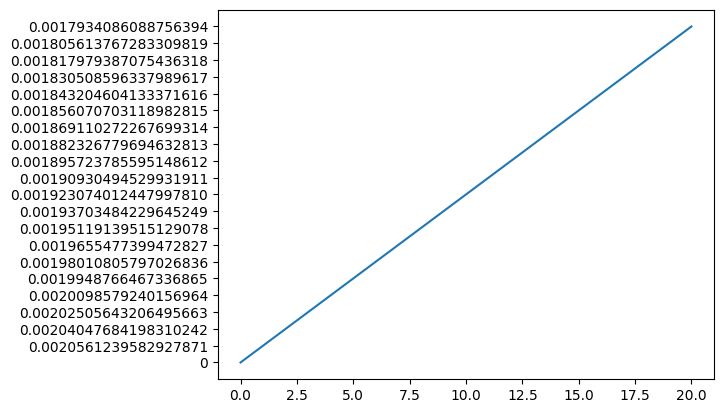

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

with open('loss_visual.txt', 'r') as file:
    data = file.read().replace('\n', '')

data = data.split(" ")
nums = [n for n in range(len(data))]
plt.plot(nums, data)



In [683]:
ypred

[Value(data=0.9817830812439714),
 Value(data=-0.9863881624765284),
 Value(data=-0.9766534529377958),
 Value(data=0.9729591216966093)]